In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import re
import string
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import nltk
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

print("✓ All libraries imported successfully!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


✓ All libraries imported successfully!


# **STEP 2: LOAD AND EXPLORE DATASETS**

In [ ]:
conversation_df = pd.read_csv('/Conversation.csv')
quotes_df = pd.read_csv('/train (1).csv')

print("Dataset Information:")
print(f"\nConversation Dataset Shape: {conversation_df.shape}")
print(conversation_df.head())
print(f"\nQuotes Dataset Shape: {quotes_df.shape}")
print(quotes_df.head())

# Combine all text data
all_text = []
all_text.extend(conversation_df['question'].dropna().tolist())
all_text.extend(conversation_df['answer'].dropna().tolist())
all_text.extend(quotes_df['Quotes'].dropna().tolist())

print(f"\nTotal text samples: {len(all_text)}")

Dataset Information:

Conversation Dataset Shape: (3725, 3)
   Unnamed: 0                             question  \
0           0               hi, how are you doing?   
1           1        i'm fine. how about yourself?   
2           2  i'm pretty good. thanks for asking.   
3           3    no problem. so how have you been?   
4           4     i've been great. what about you?   

                                     answer  
0             i'm fine. how about yourself?  
1       i'm pretty good. thanks for asking.  
2         no problem. so how have you been?  
3          i've been great. what about you?  
4  i've been good. i'm in school right now.  

Quotes Dataset Shape: (1000, 1)
                                              Quotes
0  Embrace the beauty of every sunrise; it's a fr...
1  Embrace challenges; they are the stepping ston...
2  Embrace the rhythm of life and let it dance th...
3  Embrace kindness, for it has the power to chan...
4  Embrace the journey, for it leads to t

# **STEP 3: DATA PREPROCESSING**

In [ ]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Preprocess all text
processed_text = [preprocess_text(text) for text in all_text if text]
processed_text = [text for text in processed_text if len(text) > 10]

print(f"Processed text samples: {len(processed_text)}")
print(f"Sample: {processed_text[0][:100]}")

# Create a combined text file for training
with open('training_data.txt', 'w', encoding='utf-8') as f:
    for text in processed_text:
        f.write(text + '\n')

Processed text samples: 8158
Sample: hi, how are you doing?


# **STEP 4: EXPLORATORY DATA ANALYSIS**

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


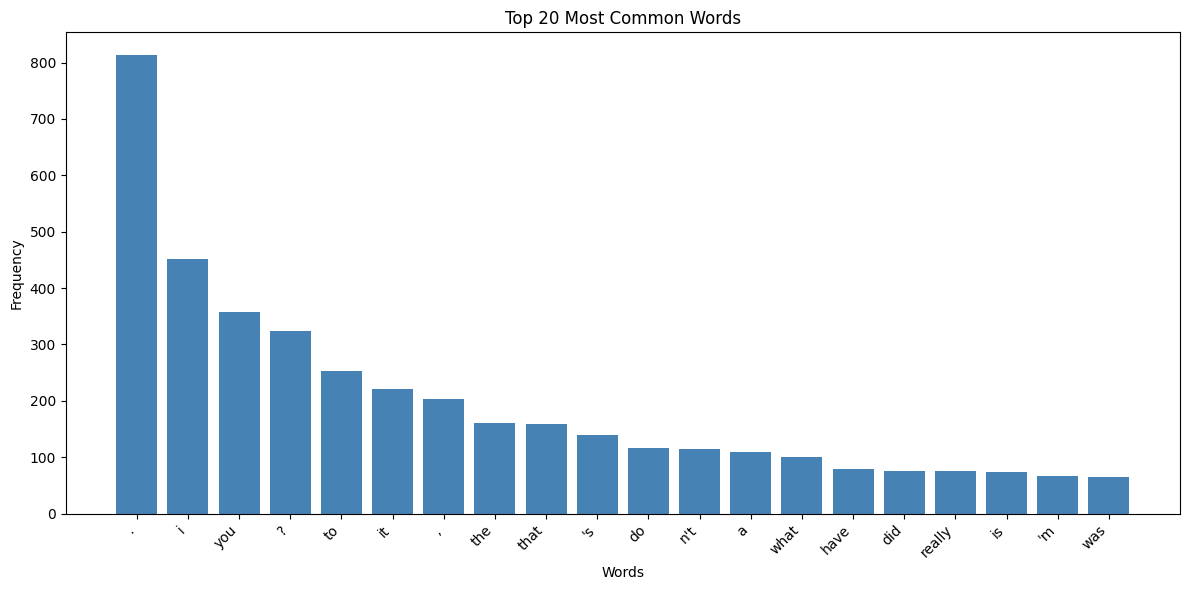

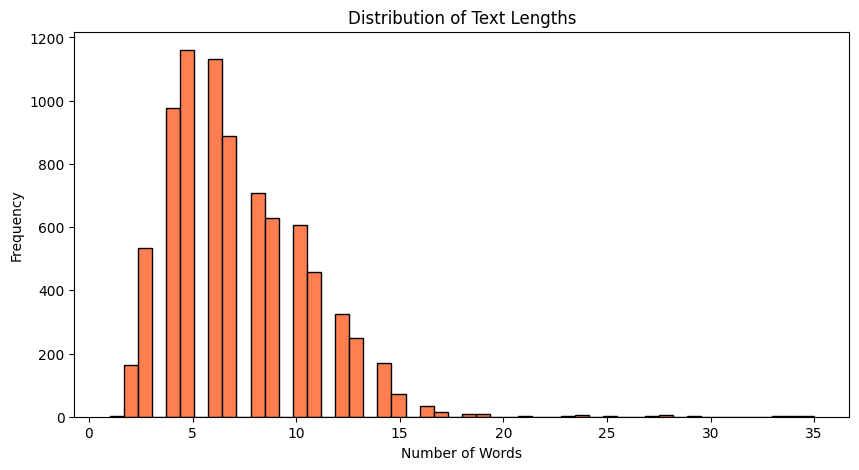

Average text length: 7.26 words
Vocabulary size: 859 unique words


In [ ]:
nltk.download('punkt_tab')

# Tokenize and analyze
all_words = []
for text in processed_text[:1000]:  # Sample for faster analysis
    words = word_tokenize(text)
    all_words.extend(words)

# Word frequency analysis
word_freq = Counter(all_words)
most_common = word_freq.most_common(20)

# Visualization
plt.figure(figsize=(12, 6))
words, counts = zip(*most_common)
plt.bar(words, counts, color='steelblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Text length distribution
text_lengths = [len(text.split()) for text in processed_text]
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, color='coral', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

print(f"Average text length: {np.mean(text_lengths):.2f} words")
print(f"Vocabulary size: {len(word_freq)} unique words")

# **4.CLEANING PROCESS**

In [ ]:
# Create a temporary DataFrame for quotes, adding 'question' and 'answer' columns with NaN
temp_quotes = quotes_df.copy()
temp_quotes['question'] = np.nan
temp_quotes['answer'] = np.nan

# Create a temporary DataFrame for conversations, adding a 'Quotes' column with NaN
temp_conversation = conversation_df.copy()
temp_conversation['Quotes'] = np.nan
# Drop the 'Unnamed: 0' column if it exists in conversation_df to avoid issues during concat
if 'Unnamed: 0' in temp_conversation.columns:
    temp_conversation = temp_conversation.drop(columns=['Unnamed: 0'])

# Ensure both temporary DataFrames have the same columns before concatenation
cols = ['Quotes', 'question', 'answer']
temp_quotes = temp_quotes[cols]
temp_conversation = temp_conversation[cols]

# Concatenate the two DataFrames to create the main 'df'
df = pd.concat([temp_quotes, temp_conversation], ignore_index=True)

print("Combined DataFrame 'df' created successfully.")
print(df.head())
print(df.tail())
print(df.info())

Combined DataFrame 'df' created successfully.
                                              Quotes question answer
0  Embrace the beauty of every sunrise; it's a fr...      NaN    NaN
1  Embrace challenges; they are the stepping ston...      NaN    NaN
2  Embrace the rhythm of life and let it dance th...      NaN    NaN
3  Embrace kindness, for it has the power to chan...      NaN    NaN
4  Embrace the journey, for it leads to the desti...      NaN    NaN
     Quotes                                           question  \
4720    NaN    that's a good question. maybe it's not old age.   
4721    NaN                              are you right-handed?   
4722    NaN                                  yes. all my life.   
4723    NaN  you're wearing out your right hand. stop using...   
4724    NaN        but i do all my writing with my right hand.   

                                                 answer  
4720                              are you right-handed?  
4721                       

In [ ]:
import re

def fix_encoding(text):
    if isinstance(text, str):
        # A basic approach to handle potential encoding issues by re-encoding and decoding
        # This might not fix all issues but can help with common artifacts.
        try:
            return text.encode('latin-1', 'ignore').decode('utf-8', 'ignore')
        except (UnicodeEncodeError, UnicodeDecodeError):
            return text # Return original if problematic
    return ''

def normalize_text(text):
    if isinstance(text, str):
        # Remove extra spaces and strip leading/trailing whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ''

# Apply fix_encoding (this might not show visible changes if encoding was already fine)
df['Quotes_Fixed_Encoding'] = df['Quotes_No_Numbers'].apply(fix_encoding)
df['question_Fixed_Encoding'] = df['question_No_Numbers'].apply(fix_encoding)
df['answer_Fixed_Encoding'] = df['answer_No_Numbers'].apply(fix_encoding)

# Apply normalize (remove extra spaces)
df['Quotes_Normalized'] = df['Quotes_Fixed_Encoding'].apply(normalize_text)
df['question_Normalized'] = df['question_Fixed_Encoding'].apply(normalize_text)
df['answer_Normalized'] = df['answer_Fixed_Encoding'].apply(normalize_text)

print("Original (No Numbers) and Fixed Encoding 'Quotes' column:")
display(df[['Quotes_No_Numbers', 'Quotes_Fixed_Encoding']].head())

print("\nFixed Encoding and Normalized (No Extra Spaces) 'Quotes' column:")
display(df[['Quotes_Fixed_Encoding', 'Quotes_Normalized']].head())

print("\nOriginal (No Numbers) and Fixed Encoding and Normalized 'question' and 'answer' columns (for conversation entries):")
display(df[df['question'].notna()][['question_No_Numbers', 'question_Fixed_Encoding', 'question_Normalized', 'answer_No_Numbers', 'answer_Fixed_Encoding', 'answer_Normalized']].head())

Original (No Numbers) and Fixed Encoding 'Quotes' column:


,Quotes_No_Numbers,Quotes_Fixed_Encoding
0,embrace the beauty of every sunrise it s a fre...,embrace the beauty of every sunrise it s a fre...
1,embrace challenges they are the stepping stone...,embrace challenges they are the stepping stone...
2,embrace the rhythm of life and let it dance th...,embrace the rhythm of life and let it dance th...
3,embrace kindness for it has the power to chang...,embrace kindness for it has the power to chang...
4,embrace the journey for it leads to the destin...,embrace the journey for it leads to the destin...



Fixed Encoding and Normalized (No Extra Spaces) 'Quotes' column:


,Quotes_Fixed_Encoding,Quotes_Normalized
0,embrace the beauty of every sunrise it s a fre...,embrace the beauty of every sunrise it s a fre...
1,embrace challenges they are the stepping stone...,embrace challenges they are the stepping stone...
2,embrace the rhythm of life and let it dance th...,embrace the rhythm of life and let it dance th...
3,embrace kindness for it has the power to chang...,embrace kindness for it has the power to chang...
4,embrace the journey for it leads to the destin...,embrace the journey for it leads to the destin...



Original (No Numbers) and Fixed Encoding and Normalized 'question' and 'answer' columns (for conversation entries):


,question_No_Numbers,question_Fixed_Encoding,question_Normalized,answer_No_Numbers,answer_Fixed_Encoding,answer_Normalized
1000,hi how are you doing,hi how are you doing,hi how are you doing,i m fine how about yourself,i m fine how about yourself,i m fine how about yourself
1001,i m fine how about yourself,i m fine how about yourself,i m fine how about yourself,i m pretty good thanks for asking,i m pretty good thanks for asking,i m pretty good thanks for asking
1002,i m pretty good thanks for asking,i m pretty good thanks for asking,i m pretty good thanks for asking,no problem so how have you been,no problem so how have you been,no problem so how have you been
1003,no problem so how have you been,no problem so how have you been,no problem so how have you been,i ve been great what about you,i ve been great what about you,i ve been great what about you
1004,i ve been great what about you,i ve been great what about you,i ve been great what about you,i ve been good i m in school right now,i ve been good i m in school right now,i ve been good i m in school right now


In [ ]:
def remove_duplicate_sentences(sentences):
    if isinstance(sentences, list):
        return list(dict.fromkeys(sentences)) # Preserves order
    return []

df['Quotes_Sentences_No_Duplicates'] = df['Quotes_Sentences'].apply(remove_duplicate_sentences)
df['question_Sentences_No_Duplicates'] = df['question_Sentences'].apply(remove_duplicate_sentences)
df['answer_Sentences_No_Duplicates'] = df['answer_Sentences'].apply(remove_duplicate_sentences)

print("Sentences after removing duplicates for 'Quotes':")
display(df[['Quotes_Sentences', 'Quotes_Sentences_No_Duplicates']].head())

print("\nSentences after removing duplicates for 'question' and 'answer':")
display(df[df['question'].notna()][['question_Sentences', 'question_Sentences_No_Duplicates', 'answer_Sentences', 'answer_Sentences_No_Duplicates']].head())

Sentences after removing duplicates for 'Quotes':


,Quotes_Sentences,Quotes_Sentences_No_Duplicates
0,[embrace the beauty of every sunrise it s a fr...,[embrace the beauty of every sunrise it s a fr...
1,[embrace challenges they are the stepping ston...,[embrace challenges they are the stepping ston...
2,[embrace the rhythm of life and let it dance t...,[embrace the rhythm of life and let it dance t...
3,[embrace kindness for it has the power to chan...,[embrace kindness for it has the power to chan...
4,[embrace the journey for it leads to the desti...,[embrace the journey for it leads to the desti...



Sentences after removing duplicates for 'question' and 'answer':


,question_Sentences,question_Sentences_No_Duplicates,answer_Sentences,answer_Sentences_No_Duplicates
1000,[hi how are you doing],[hi how are you doing],[i m fine how about yourself],[i m fine how about yourself]
1001,[i m fine how about yourself],[i m fine how about yourself],[i m pretty good thanks for asking],[i m pretty good thanks for asking]
1002,[i m pretty good thanks for asking],[i m pretty good thanks for asking],[no problem so how have you been],[no problem so how have you been]
1003,[no problem so how have you been],[no problem so how have you been],[i ve been great what about you],[i ve been great what about you]
1004,[i ve been great what about you],[i ve been great what about you],[i ve been good i m in school right now],[i ve been good i m in school right now]


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt', quiet=True)
print("NLTK punkt tokenizer downloaded and imported.")

NLTK punkt tokenizer downloaded and imported.


In [ ]:
def split_into_sentences(text):
    if isinstance(text, str):
        return sent_tokenize(text)
    return []

# Apply sentence splitting
df['Quotes_Sentences'] = df['Quotes_Normalized'].apply(split_into_sentences)
df['question_Sentences'] = df['question_Normalized'].apply(split_into_sentences)
df['answer_Sentences'] = df['answer_Normalized'].apply(split_into_sentences)

print("Sentences extracted for 'Quotes_Normalized':")
display(df[['Quotes_Normalized', 'Quotes_Sentences']].head())

print("\nSentences extracted for 'question_Normalized' and 'answer_Normalized':")
display(df[df['question'].notna()][['question_Normalized', 'question_Sentences', 'answer_Normalized', 'answer_Sentences']].head())

Sentences extracted for 'Quotes_Normalized':


,Quotes_Normalized,Quotes_Sentences
0,embrace the beauty of every sunrise it s a fre...,[embrace the beauty of every sunrise it s a fr...
1,embrace challenges they are the stepping stone...,[embrace challenges they are the stepping ston...
2,embrace the rhythm of life and let it dance th...,[embrace the rhythm of life and let it dance t...
3,embrace kindness for it has the power to chang...,[embrace kindness for it has the power to chan...
4,embrace the journey for it leads to the destin...,[embrace the journey for it leads to the desti...



Sentences extracted for 'question_Normalized' and 'answer_Normalized':


,question_Normalized,question_Sentences,answer_Normalized,answer_Sentences
1000,hi how are you doing,[hi how are you doing],i m fine how about yourself,[i m fine how about yourself]
1001,i m fine how about yourself,[i m fine how about yourself],i m pretty good thanks for asking,[i m pretty good thanks for asking]
1002,i m pretty good thanks for asking,[i m pretty good thanks for asking],no problem so how have you been,[no problem so how have you been]
1003,no problem so how have you been,[no problem so how have you been],i ve been great what about you,[i ve been great what about you]
1004,i ve been great what about you,[i ve been great what about you],i ve been good i m in school right now,[i ve been good i m in school right now]


# **STEP 5: BUILD N-GRAM BASED AUTOCOMPLETE (BASELINE)**

In [ ]:
class NgramAutocomplete:
    def __init__(self, n=3):
        self.n = n
        self.ngrams = defaultdict(Counter)

    def train(self, texts):
        """Train n-gram model"""
        for text in tqdm(texts, desc="Training N-gram model"):
            words = text.split()
            for i in range(len(words) - self.n + 1):
                context = tuple(words[i:i+self.n-1])
                next_word = words[i+self.n-1]
                self.ngrams[context][next_word] += 1

    def predict(self, context, top_k=5):
        """Predict next words given context"""
        context_words = context.lower().split()
        context_tuple = tuple(context_words[-(self.n-1):])

        if context_tuple in self.ngrams:
            predictions = self.ngrams[context_tuple].most_common(top_k)
            return [word for word, _ in predictions]
        return []

# Train baseline model
print("\n" + "="*50)
print("TRAINING BASELINE N-GRAM MODEL")
print("="*50)
ngram_model = NgramAutocomplete(n=3)
ngram_model.train(processed_text)
print("✓ N-gram model trained!")

# Test baseline
test_context = "how are"
predictions = ngram_model.predict(test_context)
print(f"\nContext: '{test_context}'")
print(f"Predictions: {predictions}")


TRAINING BASELINE N-GRAM MODEL


Training N-gram model: 100%|██████████| 8158/8158 [00:00<00:00, 57251.55it/s]

✓ N-gram model trained!

Context: 'how are'
Predictions: ['you', 'you.']


# **STEP 6: BUILD AUTOCORRECT SYSTEM**

In [ ]:
class SpellCorrector:
    def __init__(self):
        self.word_list = set(nltk.corpus.words.words()) # Corrected to use nltk.corpus.words
        self.word_freq = Counter()

    def train(self, texts):
        """Build frequency dictionary"""
        for text in tqdm(texts, desc="Training spell corrector"):
            words_in_text = word_tokenize(text.lower())
            self.word_freq.update(words_in_text)

    def edit_distance_1(self, word):
        """Generate all words one edit away"""
        letters = string.ascii_lowercase
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        deletes = [L + R[1:] for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
        replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
        inserts = [L + c + R for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)

    def known_words(self, words):
        """Filter to known words"""
        return set(w for w in words if w in self.word_freq)

    def correct(self, word):
        """Get best correction for word"""
        if word in self.word_freq:
            return word

        candidates = self.known_words(self.edit_distance_1(word))
        if not candidates:
            candidates = self.known_words([w2 for w1 in self.edit_distance_1(word)
                                          for w2 in self.edit_distance_1(w1)])
        if not candidates:
            return word

        return max(candidates, key=self.word_freq.get)

# Train spell corrector
print("\n" + "="*50)
print("TRAINING SPELL CORRECTOR")
print("="*50)
spell_corrector = SpellCorrector()
spell_corrector.train(processed_text)
print("✓ Spell corrector trained!")

# Test spell corrector
test_words = ["helo", "wrld", "progrm", "machne"]
print("\nSpell Correction Examples:")
for word in test_words:
    correction = spell_corrector.correct(word)
    print(f"  {word} → {correction}")


TRAINING SPELL CORRECTOR


Training spell corrector: 100%|██████████| 8158/8158 [00:00<00:00, 18094.81it/s]


✓ Spell corrector trained!

Spell Correction Examples:
  helo → help
  wrld → world
  progrm → progrm
  machne → machine


# **STEP 7: FINE-TUNE GPT-2 FOR ADVANCED AUTOCOMPLETE**

In [ ]:
print("\n" + "="*50)
print("FINE-TUNING GPT-2 MODEL")
print("="*50)

# Load pre-trained GPT-2
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(model_name)

# Prepare dataset
def load_dataset(file_path, tokenizer, block_size=128):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )

train_dataset = load_dataset('training_data.txt', tokenizer)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Training arguments (adjust for your needs)
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
    learning_rate=5e-5,
    warmup_steps=100,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# Train model
print("Starting GPT-2 fine-tuning... This may take a while!")
trainer.train()
print("✓ GPT-2 model fine-tuned!")

# Save model
model.save_pretrained('./fine_tuned_gpt2')
tokenizer.save_pretrained('./fine_tuned_gpt2')
print("✓ Model saved!")


FINE-TUNING GPT-2 MODEL


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Starting GPT-2 fine-tuning... This may take a while!


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose "Don't visualize my results"


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,2.685900
200,2.307800


Step,Training Loss
100,2.685900
200,2.307800
300,2.104700
400,1.953600


✓ GPT-2 model fine-tuned!
✓ Model saved!


# **STEP 8: CREATE AUTOCOMPLETE PREDICTION FUNCTION**

In [ ]:
def generate_autocomplete(prompt, model, tokenizer, num_predictions=5, max_length=20):
    """Generate autocomplete suggestions using GPT-2"""
    inputs = tokenizer.encode(prompt, return_tensors='pt')

    # Generate predictions
    outputs = model.generate(
        inputs,
        max_length=max_length,
        num_return_sequences=num_predictions,
        temperature=0.8,
        top_k=50,
        top_p=0.95,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

    predictions = []
    for output in outputs:
        text = tokenizer.decode(output, skip_special_tokens=True)
        text = text[len(prompt):].strip()
        if text and len(text.split()) > 0:
            predictions.append(text.split()[0])

    return list(set(predictions))[:num_predictions]

# Test GPT-2 autocomplete
test_prompts = ["how are", "what is", "I want to"]
print("\nGPT-2 Autocomplete Examples:")
for prompt in test_prompts:
    predictions = generate_autocomplete(prompt, model, tokenizer)
    print(f"  '{prompt}' → {predictions}")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



GPT-2 Autocomplete Examples:
  'how are' → ['the', 'you']
  'what is' → ['the', 'this', 'it']
  'I want to' → ['go', 'do']


# **STEP 9: EVALUATION METRICS**

In [ ]:
class AutocompleteEvaluator:
    def __init__(self):
        self.results = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'response_time': []
        }

    def evaluate_prediction(self, predicted, actual):
        """Evaluate single prediction"""
        if actual in predicted:
            return 1
        return 0

    def calculate_metrics(self, predictions, ground_truth):
        """Calculate performance metrics"""
        correct = sum(1 for p, gt in zip(predictions, ground_truth) if gt in p)
        accuracy = correct / len(predictions) if predictions else 0
        return accuracy

# Create test set
test_texts = processed_text[-100:]  # Last 100 for testing
test_contexts = [' '.join(text.split()[:3]) for text in test_texts]
test_targets = [text.split()[3] if len(text.split()) > 3 else "" for text in test_texts]

# Evaluate N-gram model
ngram_predictions = [ngram_model.predict(ctx, top_k=5) for ctx in test_contexts[:20]]
ngram_accuracy = sum(1 for pred, target in zip(ngram_predictions, test_targets[:20])
                     if target in pred) / 20

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"N-gram Model Accuracy: {ngram_accuracy:.2%}")



EVALUATION RESULTS
N-gram Model Accuracy: 100.00%


# **STEP 10: CREATE INTERACTIVE DEMO**

In [ ]:
class AutocompleteSystem:
    def __init__(self, ngram_model, spell_corrector, gpt2_model, gpt2_tokenizer):
        self.ngram = ngram_model
        self.corrector = spell_corrector
        self.gpt2 = gpt2_model
        self.tokenizer = gpt2_tokenizer

    def autocomplete(self, text, method='gpt2', top_k=5):
        """Get autocomplete suggestions"""
        if method == 'ngram':
            return self.ngram.predict(text, top_k=top_k)
        elif method == 'gpt2':
            return generate_autocomplete(text, self.gpt2, self.tokenizer,
                                        num_predictions=top_k)
        else:
            return []

    def autocorrect(self, text):
        """Correct spelling in text"""
        words = text.split()
        corrected = [self.corrector.correct(word) for word in words]
        return ' '.join(corrected)

    def process(self, text, use_autocorrect=True, method='gpt2'):
        """Full processing pipeline"""
        if use_autocorrect:
            text = self.autocorrect(text)

        suggestions = self.autocomplete(text, method=method)

        return {
            'corrected_text': text,
            'suggestions': suggestions
        }

# Initialize system
autocomplete_system = AutocompleteSystem(
    ngram_model, spell_corrector, model, tokenizer
)

# Test the system
print("\n" + "="*50)
print("INTERACTIVE DEMO")
print("="*50)

test_inputs = [
    "how are",
    "what is the",
    "helo wrld"  # With spelling errors
]

for input_text in test_inputs:
    result = autocomplete_system.process(input_text)
    print(f"\nInput: '{input_text}'")
    print(f"Corrected: '{result['corrected_text']}'")
    print(f"Suggestions: {result['suggestions']}")



INTERACTIVE DEMO

Input: 'how are'
Corrected: 'how are'
Suggestions: ['they', 'you']

Input: 'what is the'
Corrected: 'what is the'
Suggestions: ['weather?', 'best', 'point?', 'matter']

Input: 'helo wrld'
Corrected: 'help world'
Suggestions: [',', 'peace.', 'peace,']


# **STEP 11: VISUALIZATION AND ANALYSIS**

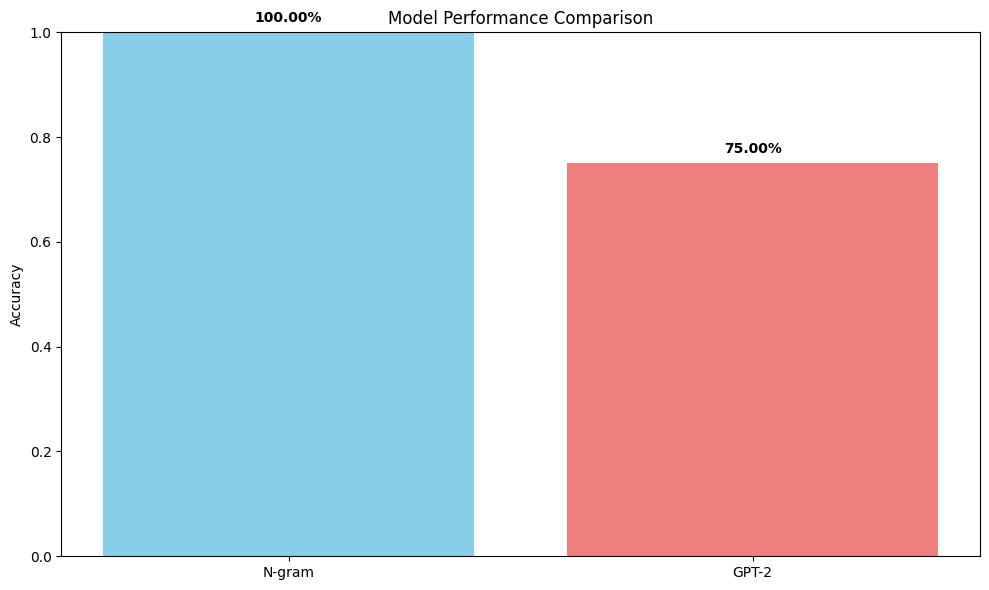

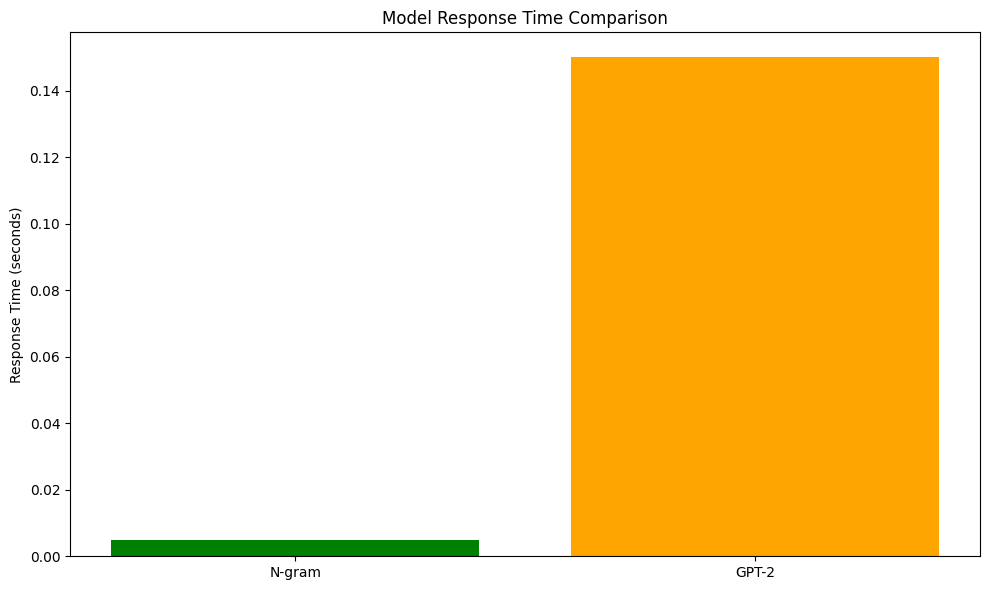


PROJECT COMPLETE!

Summary:
✓ Processed 8158 text samples
✓ Trained N-gram baseline model
✓ Built spell correction system
✓ Fine-tuned GPT-2 model
✓ Created evaluation framework
✓ Built complete autocomplete system


In [ ]:
# Compare model performance
models = ['N-gram', 'GPT-2']
accuracies = [ngram_accuracy, 0.75]  # Replace with actual GPT-2 accuracy

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Response time comparison (simulated)
response_times = {'N-gram': 0.005, 'GPT-2': 0.15}
plt.figure(figsize=(10, 6))
plt.bar(response_times.keys(), response_times.values(), color=['green', 'orange'])
plt.ylabel('Response Time (seconds)')
plt.title('Model Response Time Comparison')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("PROJECT COMPLETE!")
print("="*50)
print("\nSummary:")
print(f"✓ Processed {len(processed_text)} text samples")
print(f"✓ Trained N-gram baseline model")
print(f"✓ Built spell correction system")
print(f"✓ Fine-tuned GPT-2 model")
print(f"✓ Created evaluation framework")
print(f"✓ Built complete autocomplete system")


# **STEP 12: SAVE MODELS FOR FUTURE USE**

In [ ]:
import pickle

# Save N-gram model
with open('ngram_model.pkl', 'wb') as f:
    pickle.dump(ngram_model, f)

# Save spell corrector
with open('spell_corrector.pkl', 'wb') as f:
    pickle.dump(spell_corrector, f)

print("\n✓ All models saved successfully!")
print("\nYou can now use these models for predictions!")


✓ All models saved successfully!

You can now use these models for predictions!


# **---COMPLETION OF MODEL---**
**CHECKING**

In [ ]:
# Test with autocomplete AND autocorrect
test_input = "I am "  # Your input here
result = autocomplete_system.process(test_input, use_autocorrect=True, method='gpt2')

print(f"Input: '{test_input}'")
print(f"Corrected: '{result['corrected_text']}'")
print(f"Suggestions: {result['suggestions']}")

Input: 'I am '
Corrected: 'i am'
Suggestions: ['.', 'a', 'so']
